# 프로젝트: CutMix 또는 Mixup 비교실험 하기🖼️

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 0. 데이터 로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteU5ELKH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteU5ELKH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


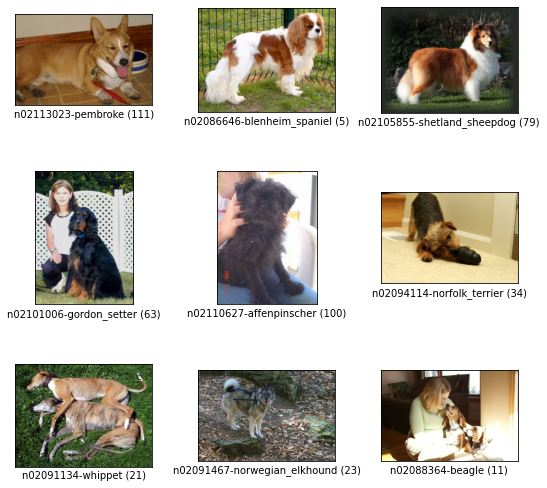

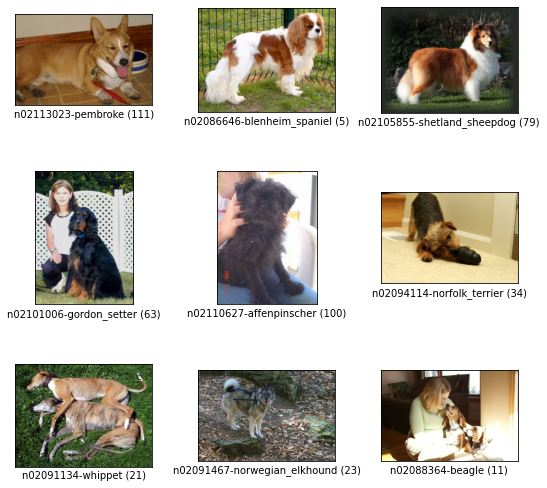

In [4]:
tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [5]:
def normalize_and_resize_img(image, label):  # float32로 nomalize, [224, 224]로 resize
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤으로 회전
    image = tf.image.random_brightness(image, max_delta=0.2)  # 랜덤으로 밝기 조절
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:  # augmentation 적용 여부 결정
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## CutMix

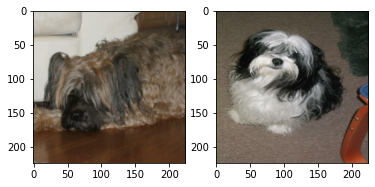

In [9]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [10]:
#  바운딩 박스의 위치 결정(image_a:배경, image_b:잘라붙일 이미지)
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(22, shape=(), dtype=int32) tf.Tensor(68, shape=(), dtype=int32)
y :  tf.Tensor(64, shape=(), dtype=int32) tf.Tensor(106, shape=(), dtype=int32)


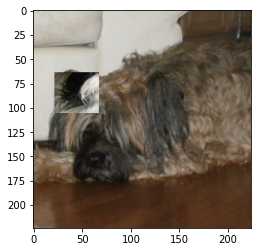

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03850446,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [13]:
# 배치 단위의 함수 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup

In [14]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

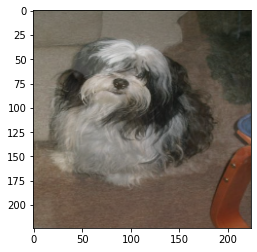

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.6706346  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.32936537 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [16]:
# 배치 단위의 함수 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 데이터셋

In [17]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 생성
* imagenet으로 훈련된 Resnet50모델 사용

In [20]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련
* cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문에 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용한다.

In [24]:
EPOCH = 20

resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [25]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 116ms/step - loss: 2.2258 - accuracy: 0.4369 - val_loss: 3.4651 - val_accuracy: 0.1982
Epoch 2/20
750/750 [==============================] - 86s 114ms/step - loss: 0.6677 - accuracy: 0.8183 - val_loss: 1.0978 - val_accuracy: 0.6799
Epoch 3/20
750/750 [==============================] - 86s 114ms/step - loss: 0.1893 - accuracy: 0.9652 - val_loss: 0.9314 - val_accuracy: 0.7317
Epoch 4/20
750/750 [==============================] - 86s 114ms/step - loss: 0.0499 - accuracy: 0.9966 - val_loss: 0.9000 - val_accuracy: 0.7415
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0201 - accuracy: 0.9997 - val_loss: 0.9192 - val_accuracy: 0.7420
Epoch 6/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9268 - val_accuracy: 0.7425
Epoch 7/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9377 - val_a

In [26]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 92s 115ms/step - loss: 2.2863 - accuracy: 0.4287 - val_loss: 2.9368 - val_accuracy: 0.2758
Epoch 2/20
750/750 [==============================] - 85s 114ms/step - loss: 0.9555 - accuracy: 0.7238 - val_loss: 1.4069 - val_accuracy: 0.6005
Epoch 3/20
750/750 [==============================] - 86s 114ms/step - loss: 0.5168 - accuracy: 0.8592 - val_loss: 1.1127 - val_accuracy: 0.6841
Epoch 4/20
750/750 [==============================] - 86s 114ms/step - loss: 0.2594 - accuracy: 0.9382 - val_loss: 0.9788 - val_accuracy: 0.7130
Epoch 5/20
750/750 [==============================] - 86s 115ms/step - loss: 0.1342 - accuracy: 0.9742 - val_loss: 0.9422 - val_accuracy: 0.7239
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0798 - accuracy: 0.9885 - val_loss: 0.9243 - val_accuracy: 0.7404
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0445 - accuracy: 0.9956 - val_loss: 0.9166 - val_ac

In [27]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 3.8404 - accuracy: 0.2083 - val_loss: 3.6427 - val_accuracy: 0.1737
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 2.9218 - accuracy: 0.4349 - val_loss: 1.3716 - val_accuracy: 0.6093
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 2.6239 - accuracy: 0.5417 - val_loss: 1.2953 - val_accuracy: 0.6456
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.4296 - accuracy: 0.6076 - val_loss: 1.1381 - val_accuracy: 0.6799
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 2.2611 - accuracy: 0.6524 - val_loss: 1.2647 - val_accuracy: 0.6587
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 2.1303 - accuracy: 0.6917 - val_loss: 1.3824 - val_accuracy: 0.6354
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 2.0519 - accuracy: 0.7173 - val_loss: 1.2041 - val_ac

In [28]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 3.7235 - accuracy: 0.2404 - val_loss: 3.6513 - val_accuracy: 0.1618
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 2.8796 - accuracy: 0.4789 - val_loss: 1.5378 - val_accuracy: 0.5708
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 2.5722 - accuracy: 0.5866 - val_loss: 1.4060 - val_accuracy: 0.6002
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 2.4295 - accuracy: 0.6442 - val_loss: 1.3423 - val_accuracy: 0.6196
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 2.2450 - accuracy: 0.7037 - val_loss: 1.2254 - val_accuracy: 0.6643
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 2.1692 - accuracy: 0.7445 - val_loss: 1.2064 - val_accuracy: 0.6618
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 2.0741 - accuracy: 0.7713 - val_loss: 1.3288 - val_ac

## 4. 훈련 과정 시각화하기

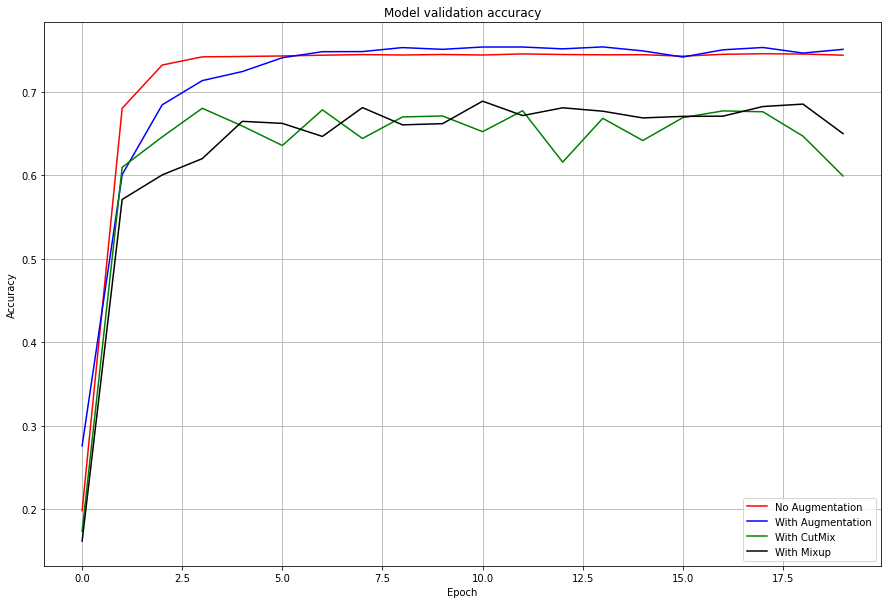

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

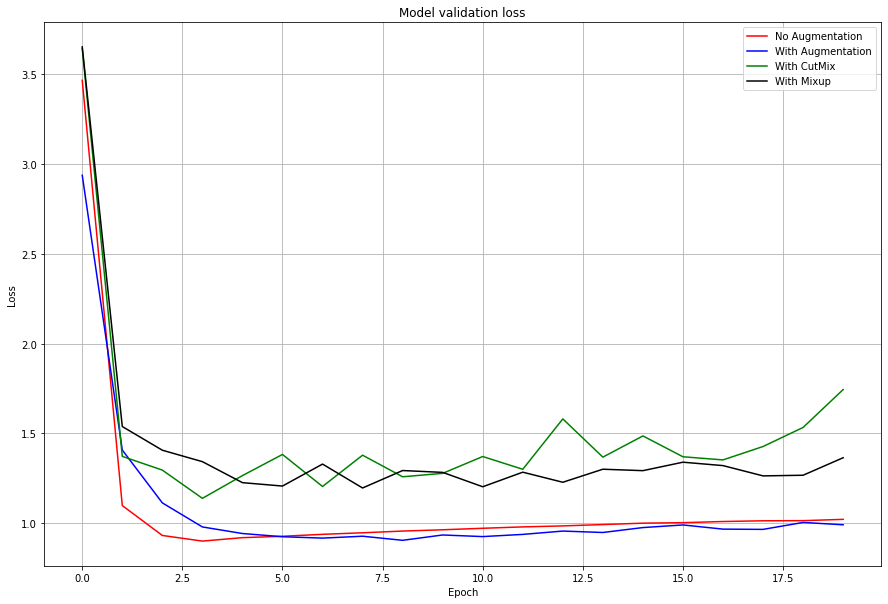

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

In [31]:
import pandas as pd

accuracy_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'],
                 'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
                 'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
                 'With Mixup': history_resnet50_mixup.history['val_accuracy']}
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.198228,0.275770,0.173741,0.161847
1,0.679921,0.600513,0.609258,0.570779
2,0.731693,0.684118,0.645639,0.600163
3,0.741488,0.713036,0.679921,0.619636
4,0.741954,0.723881,0.658699,0.664296
5,0.742537,0.740438,0.635378,0.661847
6,0.743470,0.747668,0.678055,0.646222
7,0.744170,0.747784,0.643773,0.680737
8,0.743703,0.752565,0.669543,0.660098
9,0.744286,0.750466,0.670709,0.661497


In [32]:
accuracy_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.712640,0.711806,0.629250,0.633465
std,0.121931,0.108748,0.109878,0.114940
min,0.198228,0.275770,0.173741,0.161847
25%,0.742217,0.736299,0.639838,0.648758
50%,0.743703,0.748193,0.655317,0.666336
75%,0.744286,0.751428,0.671962,0.677443
max,0.745219,0.753382,0.679921,0.688433


# 정리
* Augmentation적용모델이 가장 높은 성능을 기록했고, 아무것도 적용하지 않은 모델이 그 다음이었고, Cutmix와 Mixup적용모델은 기본모델보다 낮은 성능이 나왔다.
* 랜덤으로 바운딩 박스를 생성하여 합성했던 Cutmix는 유의미한 결과물이 나오지 않는 경우가 다수 있었던 것이 낮은 성능의 원인중 하나일 것 같고, 또한 기존 데이터셋에 기법을 적용한 이미지를 추가한 것이 아니라 대체하여 학습했기 때문에 성능 향상이 되지 않은것 같다. 